In [ ]:
!pip install mediapipe

In [ ]:
!unzip '/content/drive/MyDrive/Colab_Notebooks/Pose-detection/SL-MNIST.zip'

Archive:  /content/drive/MyDrive/Colab_Notebooks/Pose-detection/SL-MNIST.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


In [ ]:
import os
import numpy as np
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

# ◾ Read Data

In [ ]:
train_data= pd.read_csv('/content/sign_mnist_train/sign_mnist_train.csv')
print(train_data.head())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       20

In [ ]:
print(f"Number of images: {train_data.shape[0]}")
print(f"Number of pixels per image: {train_data.shape[1]}")
print(f"Number of classes: {train_data['label'].nunique()}")

Number of images: 27455
Number of pixels per image: 785
Number of classes: 24


# ◾ **Visualize Sample Images**

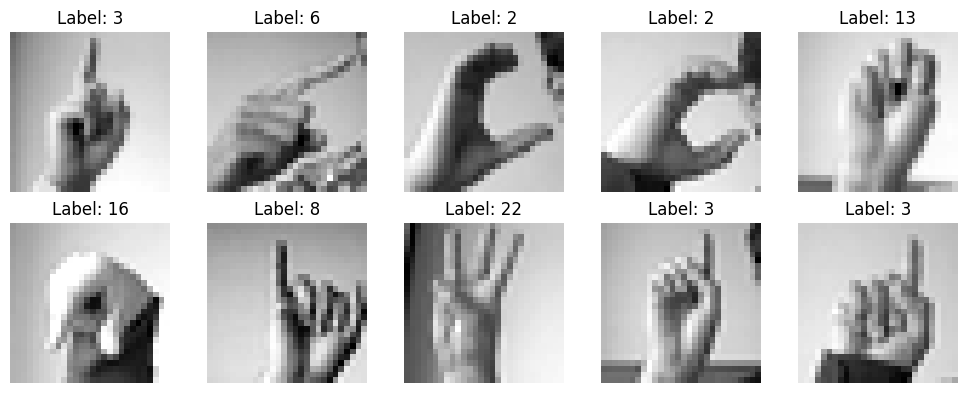

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_images(df, num_rows=2, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 2 * num_rows))  # Adjust the figsize based on your needs
    for i in range(num_rows * num_cols):
        # Calculate row and column index
        row = i // num_cols
        col = i % num_cols
        img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape the pixel values to 28x28
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f"Label: {df.iloc[i, 0]}")
    plt.tight_layout()
    plt.show()

# Displaying images
display_images(train_data, 2, 5)


In [ ]:
# num_rows= 2
# num_cols= 5
# for i in range(num_rows * num_cols):
#   # Calculate row and column index
#   row = i // num_cols
#   col = i % num_cols

#   print('i:', i)
#   print('row:', row)
#   print('col:', col)
#   print()


# **◾ Deep dive in data**

**Class Distribution**

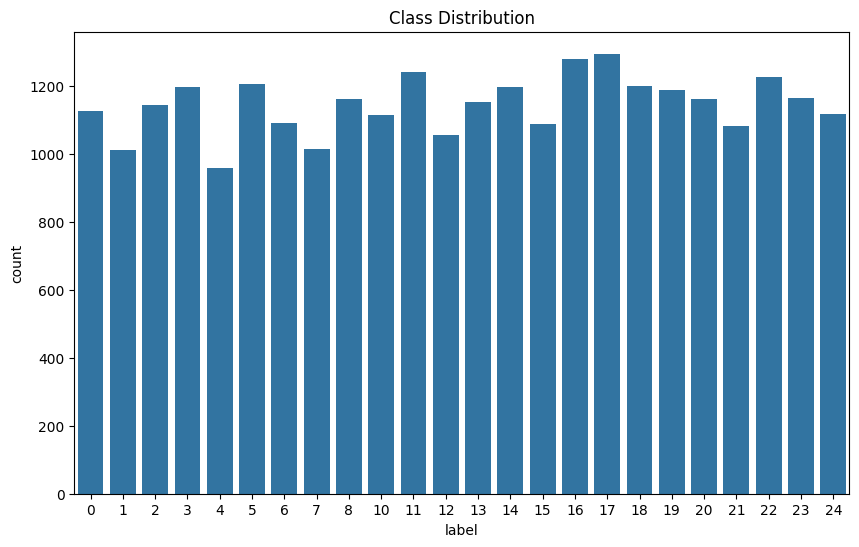

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=train_data)
plt.title('Class Distribution')
plt.show()

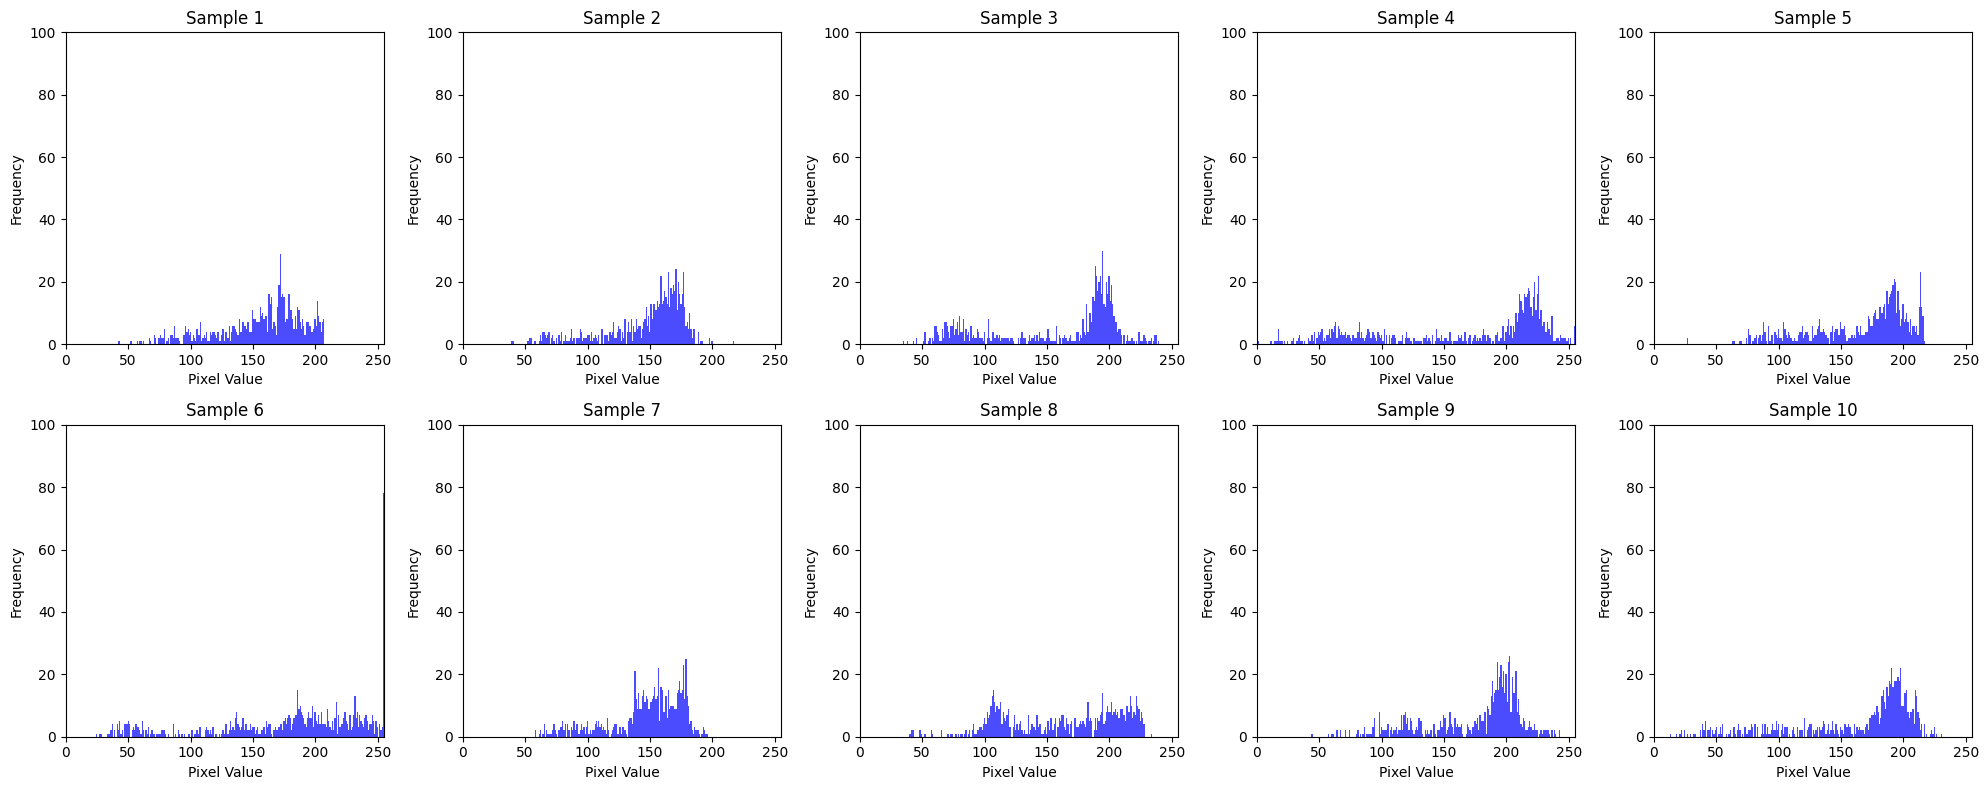

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Plotting the pixel value distribution for the 10 sample images
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for i, ax in enumerate(axes):
    img = train_data.iloc[i, 1:].values.reshape(28, 28)  # Reshape the pixel values to 28x28
    ax.hist(img.ravel(), bins=256, range=(0, 255), color='blue', alpha=0.7)
    ax.set_title(f'Sample {i+1}')
    ax.set_xlim([0, 255])
    ax.set_ylim([0, 100])  # Adjust based on your dataset's specific pixel distribution
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


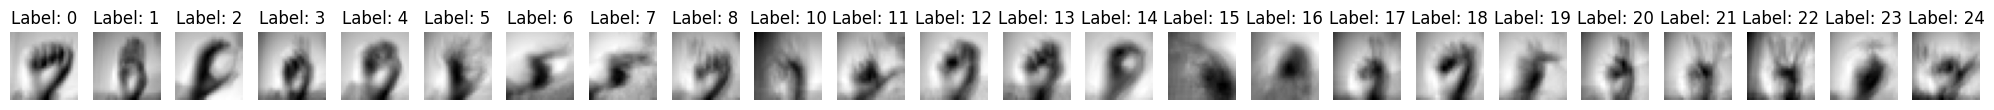

In [ ]:
# Assuming the first column is the label and the rest are pixel values
images = train_data.drop('label', axis=1).values  # Extract labels
labels = train_data['label'].values  # Extract pixel values

# Step 2: Reshape images
num_images = images.shape[0]
image_size = 28  # Assuming the images are 28x28
images = images.reshape((num_images, image_size, image_size))

# Step 3: Compute average images by class
unique_labels = np.unique(labels)

# Initialize a dictionary to hold the average image for each label
average_images_dict = {}

for label in unique_labels:
    # Select all images of the current class, compute the mean
    mean_image = np.mean(images[labels == label], axis=0)
    # Store the mean image using the label as the key
    average_images_dict[label] = mean_image

# Now, visualize the average images
fig, axes = plt.subplots(1, len(unique_labels), figsize=(20, 4))

for i, (label, avg_img) in enumerate(average_images_dict.items()):
    ax = axes[i]
    ax.imshow(avg_img.reshape((image_size, image_size)), cmap='gray')  # Reshape back to 28x28 for display
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()



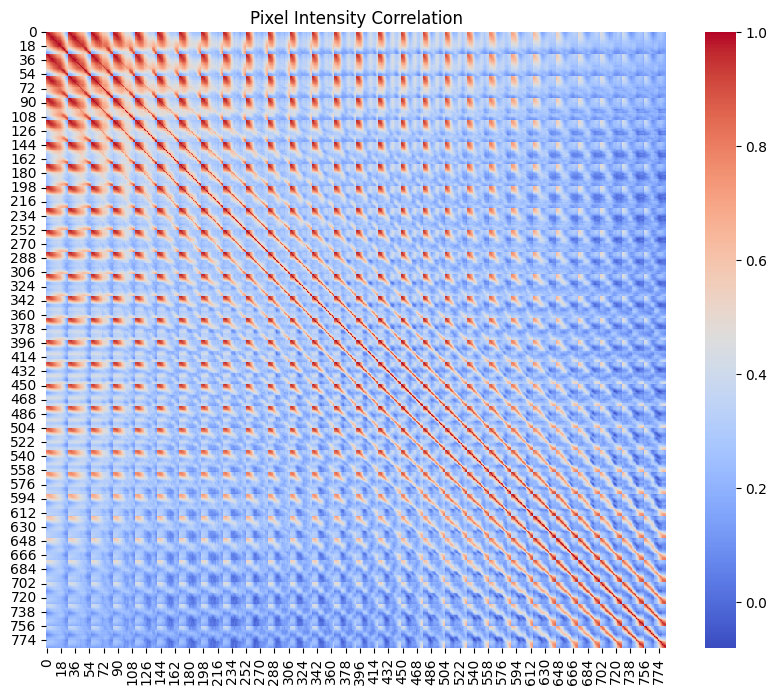

In [ ]:
import numpy as np
import seaborn as sns

# Assuming the first column is the label and the rest are pixel values
images = train_data.drop('label', axis=1).values  # Extract labels

# Step 2: Reshape images
num_images = images.shape[0]
image_size = 28  # Assuming the images are 28x28
images = images.reshape((num_images, image_size, image_size))

# Flatten each image into a single vector
flattened_images = images.reshape(num_images, -1)

# Calculate the correlation matrix
corr_matrix = np.corrcoef(flattened_images, rowvar=False)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', lw=0, linecolor='white')
plt.title("Pixel Intensity Correlation")
plt.show()


The image you've provided appears to be a heatmap generated from a Pixel Intensity Correlation analysis of a dataset, likely from sign language MNIST. Here's a step-by-step analysis of what we can infer from this heatmap:

1. **Heatmap Colors**: The heatmap uses a color scale to represent correlation coefficients, ranging from 1.0 (in red) to 0.0 (in blue). Red indicates a high positive correlation, meaning that the pixel intensities change in a similar way (either both increase or both decrease). Blue, on the other hand, indicates no correlation.

2. **Diagonal Line**: The red diagonal line suggests that every pixel is perfectly correlated with itself, which is expected because it's comparing each pixel to itself.

3. **Off-Diagonal Patterns**: The patterns we see off the diagonal are of most interest. The parallel diagonal lines in shades of red and orange, offset from the main diagonal, suggest that there are groups of pixels whose intensity changes are correlated. This could indicate features that are common across different images in the dataset, such as the edges of hand signs.

4. **Blue Background**: The predominant blue background indicates that most pairs of pixels are not correlated with each other. This lack of correlation is typical in datasets where there is a lot of variability between images, as we would expect in a dataset like sign language MNIST where different signs are represented.

5. **Implications for Sign Language MNIST**: In the context of sign language MNIST, this correlation pattern could mean that there are certain key features in the images (like edges or particular shapes) that are consistently positioned in relation to each other across different signs or different instances of the same sign. This information could be used to identify these key features for image classification tasks.

6. **Use in Machine Learning**: For machine learning, especially in convolutional neural networks (CNNs), this type of analysis might inform the design of the network architecture or the preprocessing steps. For instance, if certain pixel correlations are particularly strong, these could be features the CNN might learn to recognize as significant for classification.

7. **Further Analysis**: To derive more concrete conclusions, one would typically look at the individual images corresponding to the high-correlation pixel clusters and analyze what features those pixels represent. This might require going back to the raw images and seeing what physical features or sign language elements correspond to the correlated pixel areas.

In summary, this heatmap suggests that there are specific patterns of correlation between pixel intensities in the sign language MNIST dataset, which might correspond to meaningful features in the images. These insights could be quite useful for improving image processing and classification algorithms for this dataset.

# **◾ Pre-Process data**

![picture](https://www.researchgate.net/publication/328396430/figure/fig1/AS:683619848830976@1539999081795/The-26-letters-and-10-digits-of-American-Sign-Language-ASL.jpg)

**Move Cursor:** Directional movements (Up, Down, Left, Right) could be mapped to simple gestures.


*   left = L
*   right = R

*   up = U
*   down = D




**Left Click =** A

**Right Click =** B

**Double Click =** V

In [ ]:
classes = {'L': 11, 'R': 17, 'U': 20, 'D': 3, 'A': 0, 'B': 1, 'V': 21}
# Filter rows where the 'label' column is in the classes values
filtered_df = train_data[train_data['label'].isin(classes.values())]

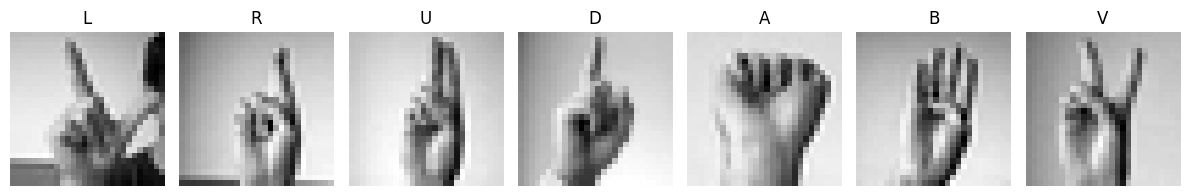

In [ ]:
# Initialize a plot
fig, axes = plt.subplots(1, len(classes), figsize=(12, 2))

# Loop over the classes and plot one image per class
for i, (gesture, label) in enumerate(classes.items()):
    # Filter the dataframe for the current class and take the first occurrence
    sample = filtered_df[filtered_df['label'] == label].iloc[0, 1:]

    # Convert the sample into a 28x28 image (reshape)
    image = sample.values.reshape(28, 28)  # Reshape to the MNIST image dimensions

    # Plot the image
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(gesture)
    axes[i].axis('off')

# Display the plot
plt.tight_layout()
plt.show()

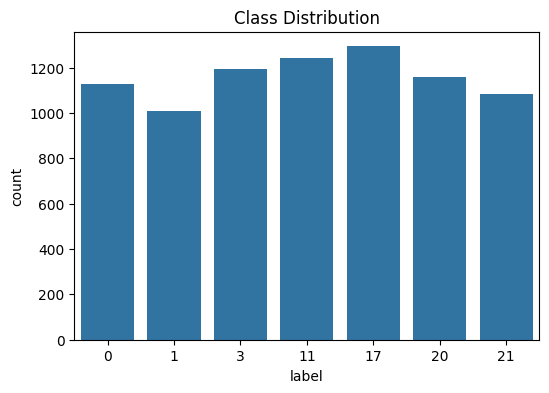

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=filtered_df)
plt.title('Class Distribution')
plt.show()

In [ ]:
X_train= filtered_df.drop('label', axis=1)
y_train= filtered_df['label']

In [ ]:
# Define the data augmentation pipeline
transforms = T.Compose([
                          T.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Rotation and translation (shifts)
                          T.RandomHorizontalFlip(p=0),  # Set probability to 0 for no flip, adjust if needed
                          T.RandomVerticalFlip(p=0),  # Set probability to 0 for no flip, adjust if needed
                          T.ColorJitter(0.2)

])

In [ ]:
label_mapping = {0: 0, 1: 1, 3: 2, 11: 3, 17: 4, 20: 5, 21: 6}

y_train = [label_mapping[label] for label in y_train]

In [ ]:
from torch.utils.data import Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, x, y, transform=None):
        """
        Args:
            x (Pandas DataFrame or similar): Input features.
            y (Pandas DataFrame or similar): Labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.x = torch.FloatTensor(x.values).reshape((-1, 1, 28, 28)) / 255.
        self.y = torch.LongTensor(y)
        self.transform = transform

    def __getitem__(self, index):
        """
        This method should return only 1 sample and label (according to "index"), not the whole dataset!
        Args:
            index (int): Index

        Returns:
            tuple: (image, label) where image is transformed.
        """
        image = self.x[index]
        label = self.y[index]

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.x)


In [ ]:
# Assuming x and y are your datasets
dataset = CustomDataset(X_train, y_train, transform= transforms)
batch_size = 64  # Number of samples per batch to load
shuffle = True   # Whether to shuffle the dataset at every epoch

train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
test_data= pd.read_csv('/content/sign_mnist_test/sign_mnist_test.csv')
filtered_test = test_data[test_data['label'].isin(classes.values())]

X_test= filtered_test.drop('label', axis=1)
y_test= filtered_test['label']

y_test = [label_mapping[label] for label in y_test]

test_dataset= CustomDataset(X_test, y_test, transform=None)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
sample_images, sample_labels= next(iter(train_loader))

In [ ]:
sample_labels

tensor([6, 6, 3, 6, 4, 0, 5, 4, 6, 4, 4, 2, 2, 3, 2, 4, 5, 2, 2, 3, 4, 4, 3, 5,
        3, 3, 1, 4, 1, 0, 3, 4, 3, 5, 1, 3, 5, 4, 3, 2, 5, 4, 5, 4, 3, 6, 1, 3,
        4, 5, 4, 6, 6, 2, 5, 4, 4, 0, 2, 2, 2, 0, 3, 4])

In [ ]:
sample_images.shape

torch.Size([64, 1, 28, 28])

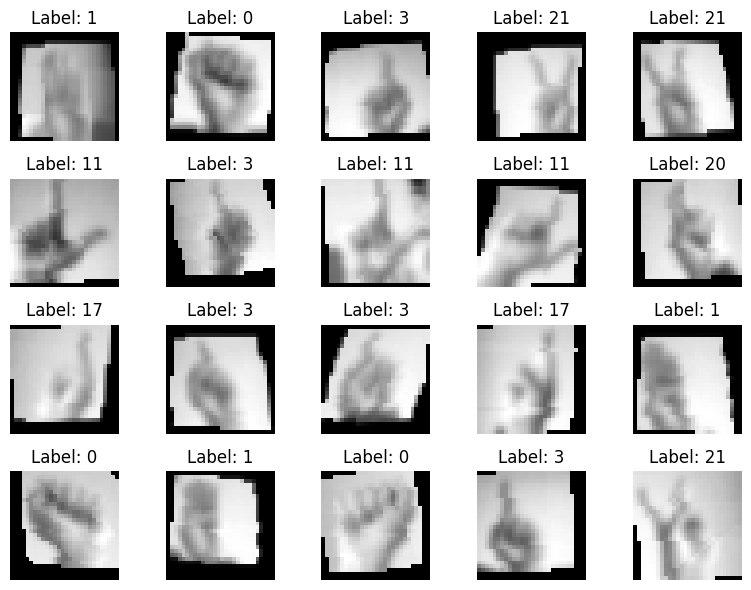

In [ ]:
import matplotlib.pyplot as plt

def imshow(img):
    # Convert tensor to numpy array and display
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)).squeeze(), cmap='gray')

# Assuming we have at least 20 images in sample_images
# Set up the matplotlib figure and axes, based on the number of images
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(8, 6))  # Adjust the figsize to fit your screen

# Plot each image in the grid
for i, ax in enumerate(axes.flat):
    if i >= len(sample_images):  # If we have fewer than 20 images, break out of the loop
        break
    ax.imshow(sample_images[i].squeeze(), cmap='gray')  # Use squeeze to remove channel dimension for grayscale
    ax.set_title(f"Label: {sample_labels[i].item()}")
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


# **◾ Utils**

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [ ]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print_txt = '\t'.join(entries)
        print(print_txt)


    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

# **◾ Deep Model**

In [ ]:
def conv3x3(in_channels, out_channels):
  """3x3 convolution with padding"""
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=1 , padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
  return module

In [ ]:
def conv3x3_drop(in_channels, out_channels):
  """3x3 convolution with padding"""
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride=1 , padding=1),
                         nn.Dropout(0.2),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
  return module

In [ ]:
class CNNModel(nn.Module):
  def __init__(self, input_channel, num_cls):
    super().__init__()

    self.conv= nn.Sequential(conv3x3(input_channel, 75),
                              nn.MaxPool2d(2,2), # 14x14

                              conv3x3(75, 50),
                              nn.MaxPool2d(2, 2), # x8

                              conv3x3_drop(50, 25),
                              nn.MaxPool2d(2, 2), # 4x4

                              conv3x3(25, 512),

                              nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                              nn.Flatten(),
                              nn.Linear(512, num_cls) # classifier
                      )


  def forward(self, x):

    y= self.conv(x)

    return y


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNNModel(1, 7).to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
y= model(sample_images)

In [ ]:
y.shape

torch.Size([64, 7])

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch):
    losses = AverageMeter('Loss', ':.4f')
    top1 = AverageMeter('Accuracy', ':6.3f')
    progress = ProgressMeter(len(train_loader),
                             [losses, top1],
                             prefix="Epoch: [{}]".format(epoch))

    # switch mode
    model.train()

    for i, (images, target) in enumerate(train_loader):

        # length = len(images)
        images = images.to(device)
        target = target.to(device)


        output = model(images)

        # compute loss
        loss = criterion(output, target)

        # measure accuracy and record loss
        acc1, _ = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print loss and accuracy
        if i % 10 == 0:
            progress.display(i)

    return model, top1.avg, losses.avg

In [ ]:
def validation(val_loader, model, criterion):
    losses = AverageMeter('Loss', ':.4f')
    top1 = AverageMeter('Accuracy', ':6.3f')
    progress = ProgressMeter(len(val_loader),
                             [losses, top1],
                             prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            images = images.to(device)
            target = target.to(device)

            # compute output
            output = model(images)
            loss = criterion(output, target)


            # measure accuracy and record loss
            acc1, _ = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))

            if i % 10 == 0:
                progress.display(i)

        print(' *** Accuracy {top1.avg:.3f}  *** '.format(top1=top1))

    return top1.avg, losses.avg

In [ ]:
x_batch, y_batch = next(iter(train_loader))
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(1.9925, grad_fn=<NllLossBackward0>)




```
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
```



In [ ]:
_, mini_train_dataset = random_split(dataset, (len(dataset)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [ ]:
model = CNNModel(1, 7).to(device)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  _, acc, loss = train(mini_train_loader, model, loss_fn, optimizer, epoch)

Epoch: [0][ 0/25]	Loss 0.3800 (0.3800)	Accuracy 90.000 (90.000)
Epoch: [0][10/25]	Loss 0.5480 (0.2676)	Accuracy 85.000 (91.818)
Epoch: [0][20/25]	Loss 0.0987 (0.2356)	Accuracy 100.000 (92.857)
Epoch: [1][ 0/25]	Loss 0.5440 (0.5440)	Accuracy 90.000 (90.000)
Epoch: [1][10/25]	Loss 0.1606 (0.2256)	Accuracy 100.000 (95.000)
Epoch: [1][20/25]	Loss 0.2869 (0.1980)	Accuracy 90.000 (95.714)
Epoch: [2][ 0/25]	Loss 0.6922 (0.6922)	Accuracy 80.000 (80.000)
Epoch: [2][10/25]	Loss 0.2113 (0.2433)	Accuracy 95.000 (93.636)
Epoch: [2][20/25]	Loss 0.1793 (0.2153)	Accuracy 90.000 (93.810)
Epoch: [3][ 0/25]	Loss 0.2776 (0.2776)	Accuracy 85.000 (85.000)
Epoch: [3][10/25]	Loss 0.2281 (0.1626)	Accuracy 90.000 (95.000)
Epoch: [3][20/25]	Loss 0.0965 (0.1647)	Accuracy 100.000 (95.000)
Epoch: [4][ 0/25]	Loss 0.3682 (0.3682)	Accuracy 90.000 (90.000)
Epoch: [4][10/25]	Loss 0.1111 (0.2172)	Accuracy 100.000 (94.091)
Epoch: [4][20/25]	Loss 0.1203 (0.1687)	Accuracy 100.000 (95.714)
Epoch: [5][ 0/25]	Loss 0.0873 (0.08

In [ ]:
num_epochs = 2
for lr in [0.1, 0.01]:
  print(f'LR={lr}')
  model = model = CNNModel(1, 7).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, acc,loss = train(train_loader, model, loss_fn, optimizer, epoch)
  print()

LR=0.1
Epoch: [0][  0/811]	Loss 2.0132 (2.0132)	Accuracy 20.000 (20.000)
Epoch: [0][ 10/811]	Loss 1.7542 (2.2840)	Accuracy 20.000 (19.091)
Epoch: [0][ 20/811]	Loss 1.5255 (2.1455)	Accuracy 30.000 (22.381)
Epoch: [0][ 30/811]	Loss 1.9442 (2.2002)	Accuracy 20.000 (20.968)
Epoch: [0][ 40/811]	Loss 2.3420 (2.1228)	Accuracy 10.000 (23.902)
Epoch: [0][ 50/811]	Loss 1.6333 (1.9977)	Accuracy 30.000 (27.843)
Epoch: [0][ 60/811]	Loss 0.9777 (1.8436)	Accuracy 60.000 (33.443)
Epoch: [0][ 70/811]	Loss 0.7688 (1.7297)	Accuracy 70.000 (36.761)
Epoch: [0][ 80/811]	Loss 1.1770 (1.6235)	Accuracy 50.000 (40.617)
Epoch: [0][ 90/811]	Loss 0.6004 (1.5407)	Accuracy 80.000 (43.407)
Epoch: [0][100/811]	Loss 0.6360 (1.4646)	Accuracy 70.000 (45.941)
Epoch: [0][110/811]	Loss 0.9751 (1.3878)	Accuracy 70.000 (49.279)
Epoch: [0][120/811]	Loss 0.6752 (1.3200)	Accuracy 80.000 (52.149)
Epoch: [0][130/811]	Loss 0.4072 (1.2662)	Accuracy 100.000 (54.580)
Epoch: [0][140/811]	Loss 0.3813 (1.2063)	Accuracy 80.000 (56.950)
Ep

In [ ]:
num_epochs = 5

for lr in [0.1, 0.01, 0.001, 0.15]:
  for wd in [1e-4, 1e-5, 0.]:
    model = CNNModel().to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      model, loss, _ = train(train_loader,model, loss_fn, optimizer, epoch)
    print()

In [ ]:
model = CNNModel(1,7).to(device)

In [ ]:
lr = 0.1
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train(train_loader, model,
                                        loss_fn,
                                        optimizer,
                                        epoch)
  # Validation
  loss_valid, acc_valid = validation(test_loader, model,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch: [0][  0/127]	Loss 2.0011 (2.0011)	Accuracy 14.062 (14.062)
Epoch: [0][ 10/127]	Loss 1.9500 (1.9581)	Accuracy 14.062 (17.472)
Epoch: [0][ 20/127]	Loss 1.9097 (1.8859)	Accuracy 21.875 (23.289)
Epoch: [0][ 30/127]	Loss 1.3947 (1.7563)	Accuracy 51.562 (30.192)
Epoch: [0][ 40/127]	Loss 1.1967 (1.6315)	Accuracy 57.812 (35.938)
Epoch: [0][ 50/127]	Loss 1.0608 (1.5245)	Accuracy 59.375 (41.299)
Epoch: [0][ 60/127]	Loss 0.7288 (1.4276)	Accuracy 75.000 (44.980)
Epoch: [0][ 70/127]	Loss 0.6956 (1.3451)	Accuracy 81.250 (48.438)
Epoch: [0][ 80/127]	Loss 0.6793 (1.2644)	Accuracy 82.812 (51.987)
Epoch: [0][ 90/127]	Loss 0.7990 (1.2143)	Accuracy 65.625 (53.846)
Epoch: [0][100/127]	Loss 0.5441 (1.1489)	Accuracy 85.938 (56.838)
Epoch: [0][110/127]	Loss 0.4369 (1.0910)	Accuracy 85.938 (59.248)
Epoch: [0][120/127]	Loss 0.3505 (1.0327)	Accuracy 89.062 (61.790)
Test: [ 0/31]	Loss 0.9926 (0.9926)	Accuracy 57.812 (57.812)
Test: [10/31]	Loss 0.7900 (0.8344)	Accuracy 65.625 (62.216)
Test: [20/31]	Loss 0.8

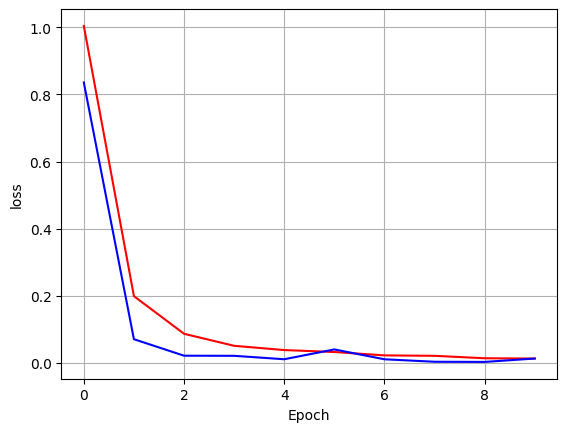

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)

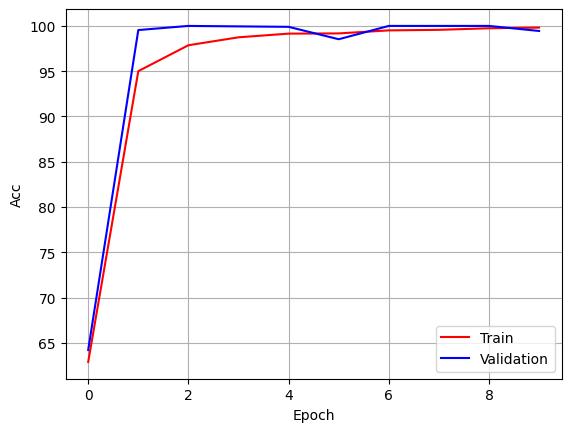

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()

In [ ]:
# Save
#torch.save(model.state_dict(), 'model_state_dict.pth')

# Load
model_L = CNNModel(1, 7)  # Initialize the model as you did before
model_L.load_state_dict(torch.load('model_state_dict.pth'))
model_L.eval()  # Set the model to inference mode

CNNModel(
  (conv): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 75, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(75, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(75, 50, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(50, 25, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Dropout(p=0.2, inplace=False)
      (2): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
    )
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Sequential(
      (0): Conv2

In [ ]:
# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

# No need to track gradients for validation, hence wrap in torch.no_grad to save memory and computations
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)

        outputs = model_L(inputs)

        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

In [ ]:
# Compute the accuracy
correct = predlist.eq(lbllist).sum().item()
total = len(test_dataset)
accuracy = correct / total
print(f'Accuracy of the network on the test images: {accuracy * 100:.2f}%')


Accuracy of the network on the test images: 99.44%
